# **<center>SQL interview Preparation</center>**
* **6 important SQL questions for goods handson including joins, filter, cte and windows function**



In [2]:
#  Installing db-sqlite3 
# !pip install db-sqlite3

In [3]:
import pandas as pd
import sqlite3
from datetime import date

In [4]:
#connecting and creating with the database.
db = sqlite3.connect("testing.db")
db.execute("drop table if exists results")

## **1. Derrive points table for ICC tournaments**

In [5]:
# Create table
try:
  db.execute("create table icc_world_cup(Team_1 Varchar(20),Team_2 Varchar(20),Winner Varchar(20))")
except:
  print("Already table existed !!")
# Insert values
input = [
"INSERT INTO icc_world_cup values('India','SL','India');",
"INSERT INTO icc_world_cup values('SL','Aus','Aus');",
"INSERT INTO icc_world_cup values('SA','Eng','Eng');",
"INSERT INTO icc_world_cup values('Eng','NZ','NZ');",
"INSERT INTO icc_world_cup values('Aus','India','India');"]
for i in input:
  db.execute(i)
  db.commit()

In [6]:
qry = """
select * from icc_world_cup;
"""
pd.read_sql_query(qry, db)     


,Team_1,Team_2,Winner
0,India,SL,India
1,SL,Aus,Aus
2,SA,Eng,Eng
3,Eng,NZ,NZ
4,Aus,India,India


**Expected Output:**

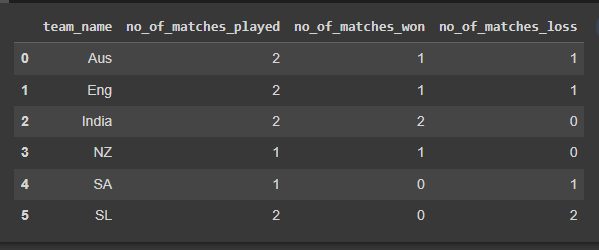

In [7]:
qry = """
select 
team_name, 
count(1) as no_of_matches_played,
sum(winner_flag) as no_of_matches_won,
count(1)-sum(winner_flag) as no_of_matches_loss
from
(select 
Team_1 as team_name, 
case when Winner=Team_1 then 1 else 0 end as winner_flag
from icc_world_cup
union all
select 
Team_2 as team_name, 
case when Winner=Team_2 then 1 else 0 end as winner_flag
from icc_world_cup) A
group by 1
"""
pd.read_sql_query(qry, db)     

,team_name,no_of_matches_played,no_of_matches_won,no_of_matches_loss
0,Aus,2,1,1
1,Eng,2,1,1
2,India,2,2,0
3,NZ,1,1,0
4,SA,1,0,1
5,SL,2,0,2


## **2. Find new and repeat customers**

In [8]:
# Create table
try:
  db.execute("""create table customer_orders (
order_id integer,
customer_id integer,
order_date datetime,
order_amount integer
);""")
except:
  print("Already table existed !!")
# Insert values
input = [
"""insert into customer_orders values
(1,100,date('2022-01-01'),2000),
(2,200,date('2022-01-01'),2500),
(3,300,date('2022-01-01'),2100),
(4,100,date('2022-01-02'),2000),
(5,400,date('2022-01-02'),2200),
(6,500,date('2022-01-02'),2700),
(7,100,date('2022-01-03'),3000),
(8,400,date('2022-01-03'),1000),
(9,600,date('2022-01-03'),3000)
;"""
]
for i in input:
  db.execute(i)
  db.commit()

In [9]:
qry = """
select * from customer_orders;
"""
pd.read_sql_query(qry, db)     


,order_id,customer_id,order_date,order_amount
0,1,100,2022-01-01,2000
1,2,200,2022-01-01,2500
2,3,300,2022-01-01,2100
3,4,100,2022-01-02,2000
4,5,400,2022-01-02,2200
5,6,500,2022-01-02,2700
6,7,100,2022-01-03,3000
7,8,400,2022-01-03,1000
8,9,600,2022-01-03,3000


**Expected Output:**

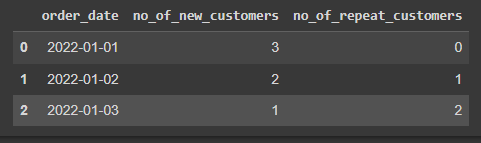

In [10]:
qry = """
with first_visit as (
select 
customer_id,
min(order_date) as first_visit_date 
from customer_orders
group by 1
),

visit_flag as (
select 
co.*, first_visit_date,
case when co.order_date=fv.first_visit_date  then 1 else 0 end as first_visit_flag ,
case when co.order_date!=fv.first_visit_date  then 1 else 0 end as repeat_visit_flag 
from customer_orders co
inner join first_visit fv
on co.customer_id=fv.customer_id
)

select 
order_date, 
sum(first_visit_flag) as no_of_new_customers,
sum(repeat_visit_flag) as no_of_repeat_customers
from visit_flag
group by 1
"""
pd.read_sql_query(qry, db)     


,order_date,no_of_new_customers,no_of_repeat_customers
0,2022-01-01,3,0
1,2022-01-02,2,1
2,2022-01-03,1,2


## **3.  Scenario based question**

In [11]:
# Create table
try:
  db.execute("""
  create table entries ( 
  name varchar(20),
  address varchar(20),
  email varchar(20),
  floor int,
  resources varchar(10));
  """)
except:
  print("Already table existed !!")
# Insert values
input = ["""
insert into entries values 
('A','Bangalore','A@gmail.com',1,'CPU'),
('A','Bangalore','A1@gmail.com',1,'CPU'),
('A','Bangalore','A2@gmail.com',2,'DESKTOP'),
('B','Bangalore','B@gmail.com',2,'DESKTOP'),
('B','Bangalore','B1@gmail.com',2,'DESKTOP'),
('B','Bangalore','B2@gmail.com',1,'MONITOR')
"""]
for i in input:
  db.execute(i)
  db.commit()

In [12]:
qry = """
select 
* 
from entries
"""
pd.read_sql_query(qry, db)     


,name,address,email,floor,resources
0,A,Bangalore,A@gmail.com,1,CPU
1,A,Bangalore,A1@gmail.com,1,CPU
2,A,Bangalore,A2@gmail.com,2,DESKTOP
3,B,Bangalore,B@gmail.com,2,DESKTOP
4,B,Bangalore,B1@gmail.com,2,DESKTOP
5,B,Bangalore,B2@gmail.com,1,MONITOR


**Expected Output:**

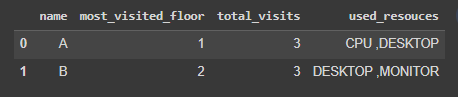

In [13]:
qry = """
with floor_visit as(
select 
name, floor, count(1) as no_of_floor_visits,
rank() over(partition by name order by count(1) desc) as rn
from entries
group by 1,2
),
total_visit as(
select 
name, 
count(1) as total_visits, 
group_concat(resources,' ,') as resouces_uses 
from entries group by 1
),
distinct_resources as(
select 
distinct name, 
resources from entries
),
agg_resources as (
select 
name, 
group_concat(resources,' ,') as used_resouces 
from distinct_resources
group by 1
)

select 
fv.name,
fv.floor as most_visited_floor,
tv.total_visits,
ar.used_resouces
from floor_visit fv
inner join total_visit tv
on fv.name = tv.name
inner join agg_resources ar
on fv.name = ar.name
where fv.rn=1
"""
pd.read_sql_query(qry, db)     


,name,most_visited_floor,total_visits,used_resouces
0,A,1,3,"CPU ,DESKTOP"
1,B,2,3,"DESKTOP ,MONITOR"


## **4. Write a query to find PersonID, Name, number of friends, sum of marks of person who have friends with total score greater than 100**

In [14]:
import os
os.chdir('/content/drive/MyDrive/Interview Related Documents/SQL/Datasets')
os.getcwd()

'/content/drive/MyDrive/Interview Related Documents/SQL/Datasets'

In [15]:
df_person = pd.read_excel("person.xlsx")
df_friend = pd.read_excel("friend.xls")
df_person.to_sql("person", db, if_exists='append', index=False)
df_friend.to_sql("friend", db, if_exists='append', index=False)

**Expected Output:**

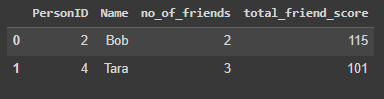

In [16]:
qry = """
select * from person;
"""
pd.read_sql_query(qry, db)     


,PersonID,Name,Email,Score
0,1,Alice,alice2018@hotmail.com,88
1,2,Bob,bob2018@hotmail.com,11
2,3,Davis,davis2018@hotmail.com,27
3,4,Tara,tara2018@hotmail.com,45
4,5,John,john2018@hotmail.com,63


In [17]:
qry = """
select * from friend;
"""
pd.read_sql_query(qry, db)     


,PersonID,FriendID
0,1,2
1,1,3
2,2,1
3,2,3
4,3,5
5,4,2
6,4,3
7,4,5


In [26]:
qry = """
with score_details as (
select 
f.PersonID, 
count(1) as no_of_friends,
sum(P.Score) as total_friend_score
from friend f inner join person p
on f.friendID = p.PersonID
group by 1
having sum(P.Score)>100
)

select
s.PersonID,
p.Name, 
s.no_of_friends,
s.total_friend_score
from score_details s inner join person p
on s.PersonID = p.PersonID 
"""
# We used having for filter in aggregated columns
pd.read_sql_query(qry, db)     


,PersonID,Name,no_of_friends,total_friend_score
0,2,Bob,2,115
1,4,Tara,3,101


## **5. Pareto Principle (80/20 Rule)**

* The Pareto Principle states that for many outcomes, roughly 80 % of consequences come from 20 % of causes.
* Examples:
  * 80 % of the productivity come from 20 % of the employee
  * 80 % of your sales come from 20 % of your clients
  * 80 % of your sales comes from 20 % of your product or services  

* **Our goal is to find which are top 20 % products wwhich are giving 80 % of the sales.**

In [28]:
df_orders = pd.read_excel("Superstore_orders.xls")
df_orders.to_sql("orders", db, if_exists='append', index=False)

In [30]:
qry = """
select 
* 
from orders
"""
pd.read_sql_query(qry, db).head()     


,Row_ID,Order_ID,Order_Date,Ship_Date,Ship_Mode,Customer_ID,Customer_Name,Segment,Country/Region,City,...,Postal_Code,Region,Product_ID,Category,Sub_Category,Product_Name,Sales,Quantity,Discount,Profit
0,1,CA-2020-152156,2020-11-08 00:00:00,2020-11-11 00:00:00,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2020-152156,2020-11-08 00:00:00,2020-11-11 00:00:00,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2020-138688,2020-06-12 00:00:00,2020-06-16 00:00:00,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2019-108966,2019-10-11 00:00:00,2019-10-18 00:00:00,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2019-108966,2019-10-11 00:00:00,2019-10-18 00:00:00,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


**Expected Output:** Top 20 % products which are contributing 80 % of the sales

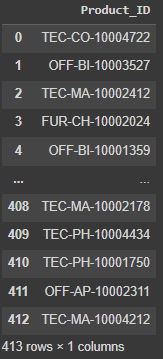

In [43]:
qry = """
with product_wise_sales as(
select 
Product_ID,
sum(Sales) as product_sales
from orders
group by 1
order by product_sales desc
),
cal_sales as(
select 
Product_ID,
product_sales,
sum(product_sales) over(order by product_sales desc rows between unbounded preceding and 0 preceding) as running_sales,
0.8*sum(product_sales) over() as total_sales
from product_wise_sales
)
select 
Product_ID
from cal_sales
where running_sales <= total_sales
"""
pd.read_sql_query(qry, db)     


,Product_ID
0,TEC-CO-10004722
1,OFF-BI-10003527
2,TEC-MA-10002412
3,FUR-CH-10002024
4,OFF-BI-10001359
...,...
408,TEC-MA-10002178
409,TEC-PH-10004434
410,TEC-PH-10001750
411,OFF-AP-10002311


## **6. Trips and Users**
* Write a SQL query  to find the cancellation rate of requests with unbanned users (both client and driver must not be banned) each day between "2013-10-01" and "2013-10-03". Round cancellation Rate to two decimal points
* *The cancelation rate is computed by dividing the number of canceled (by client or driver) requests with unbanned users by the total number of requests with unbanned users on that day*

In [44]:
# Create table
try:
  db.execute("""
  Create table Trips (id int, client_id int, driver_id int, city_id int, status varchar(50), request_at varchar(50));
  """)
  db.execute("""
  Create table Users (users_id int, banned varchar(50), role varchar(50));
  """)

except:
  print("Already table existed !!")
  
# Insert values
input_trips = [
"insert into Trips (id, client_id, driver_id, city_id, status, request_at) values ('1', '1', '10', '1', 'completed', '2013-10-01');",
"insert into Trips (id, client_id, driver_id, city_id, status, request_at) values ('2', '2', '11', '1', 'cancelled_by_driver', '2013-10-01');",
"insert into Trips (id, client_id, driver_id, city_id, status, request_at) values ('3', '3', '12', '6', 'completed', '2013-10-01');",
"insert into Trips (id, client_id, driver_id, city_id, status, request_at) values ('4', '4', '13', '6', 'cancelled_by_client', '2013-10-01');",
"insert into Trips (id, client_id, driver_id, city_id, status, request_at) values ('5', '1', '10', '1', 'completed', '2013-10-02');",
"insert into Trips (id, client_id, driver_id, city_id, status, request_at) values ('6', '2', '11', '6', 'completed', '2013-10-02');",
"insert into Trips (id, client_id, driver_id, city_id, status, request_at) values ('7', '3', '12', '6', 'completed', '2013-10-02');",
"insert into Trips (id, client_id, driver_id, city_id, status, request_at) values ('8', '2', '12', '12', 'completed', '2013-10-03');",
"insert into Trips (id, client_id, driver_id, city_id, status, request_at) values ('9', '3', '10', '12', 'completed', '2013-10-03');",
"insert into Trips (id, client_id, driver_id, city_id, status, request_at) values ('10', '4', '13', '12', 'cancelled_by_driver', '2013-10-03');"
]
for i in input_trips:
  db.execute(i)
  db.commit()
input_users = [
"insert into Users (users_id, banned, role) values ('1', 'No', 'client');",
"insert into Users (users_id, banned, role) values ('2', 'Yes', 'client');",
"insert into Users (users_id, banned, role) values ('3', 'No', 'client');",
"insert into Users (users_id, banned, role) values ('4', 'No', 'client');",
"insert into Users (users_id, banned, role) values ('10', 'No', 'driver');",
"insert into Users (users_id, banned, role) values ('11', 'No', 'driver');",
"insert into Users (users_id, banned, role) values ('12', 'No', 'driver');",
"insert into Users (users_id, banned, role) values ('13', 'No', 'driver');"
]
for i in input_users:
  db.execute(i)
  db.commit()

In [45]:
qry = """
select 
* 
from Trips
"""
pd.read_sql_query(qry, db)     


,id,client_id,driver_id,city_id,status,request_at
0,1,1,10,1,completed,2013-10-01
1,2,2,11,1,cancelled_by_driver,2013-10-01
2,3,3,12,6,completed,2013-10-01
3,4,4,13,6,cancelled_by_client,2013-10-01
4,5,1,10,1,completed,2013-10-02
5,6,2,11,6,completed,2013-10-02
6,7,3,12,6,completed,2013-10-02
7,8,2,12,12,completed,2013-10-03
8,9,3,10,12,completed,2013-10-03
9,10,4,13,12,cancelled_by_driver,2013-10-03


In [46]:
qry = """
select 
* 
from Users
"""
pd.read_sql_query(qry, db)     


,users_id,banned,role
0,1,No,client
1,2,Yes,client
2,3,No,client
3,4,No,client
4,10,No,driver
5,11,No,driver
6,12,No,driver
7,13,No,driver


**Expected Output:**

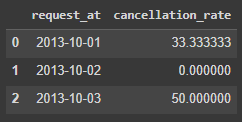

In [60]:
qry = """
with unbanned_users_trips as(
select 
* 
from Trips t 
inner join Users u on t.client_id = u.users_id
inner join Users d on t.driver_id = d.users_id
where u.banned = 'No' and d.banned = 'No'
),
cancelled_trips_cal as(
select 
request_at,
count(case when status in ('cancelled_by_client', 'cancelled_by_driver') then 1 else null end) as cancelled_trips_count,
count(1) as total_trips
from unbanned_users_trips
group by 1
)
select 
request_at,(cancelled_trips_count*1.0/total_trips)*100 as cancellation_rate
from cancelled_trips_cal
"""
pd.read_sql_query(qry, db)     


,request_at,cancellation_rate
0,2013-10-01,33.333333
1,2013-10-02,0.000000
2,2013-10-03,50.000000


**Source:**
* https://www.youtube.com/playlist?list=PLBTZqjSKn0IeKBQDjLmzisazhqQy4iGkb

# **<center>THE END</center>**